<h2 style="color:crimson">Ejercicio</h2>

1. Entrena y calibra un árbol de decisión para la base de datos `moons`
    * Genera una base de datos usando `make_moons(n_samples=10_000, noise=0.4, random_state=25)` (la función se importa desde `sklearn.datasets`)
    * Divide entre *train* y *test* set usando `train_test_split`
    * Realiza una búsqueda con cross-validation para encontrar hiperparámetros que mejoren un modelo de `DecisionTreeClassifier`. **Comenta tus resultados y lo que encontró el modelo**

In [2]:
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
from tqdm.notebook import tqdm
from time import sleep
from sklearn.datasets import make_moons
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_validate

### Generación de la base datos usando la función 'make_moons'

In [4]:
moons = make_moons(n_samples=10_000, noise=0.4, random_state=25)

In [32]:
csel = ColumnTransformer([
    ("ohe", OneHotEncoder(sparse=False, categories=[categories]), ["GICS Sector"])
], remainder="passthrough")

pipe = Pipeline([
    ("col_sel", csel),
    ("tree", DecisionTreeClassifier(max_depth=5, random_state=314))
])

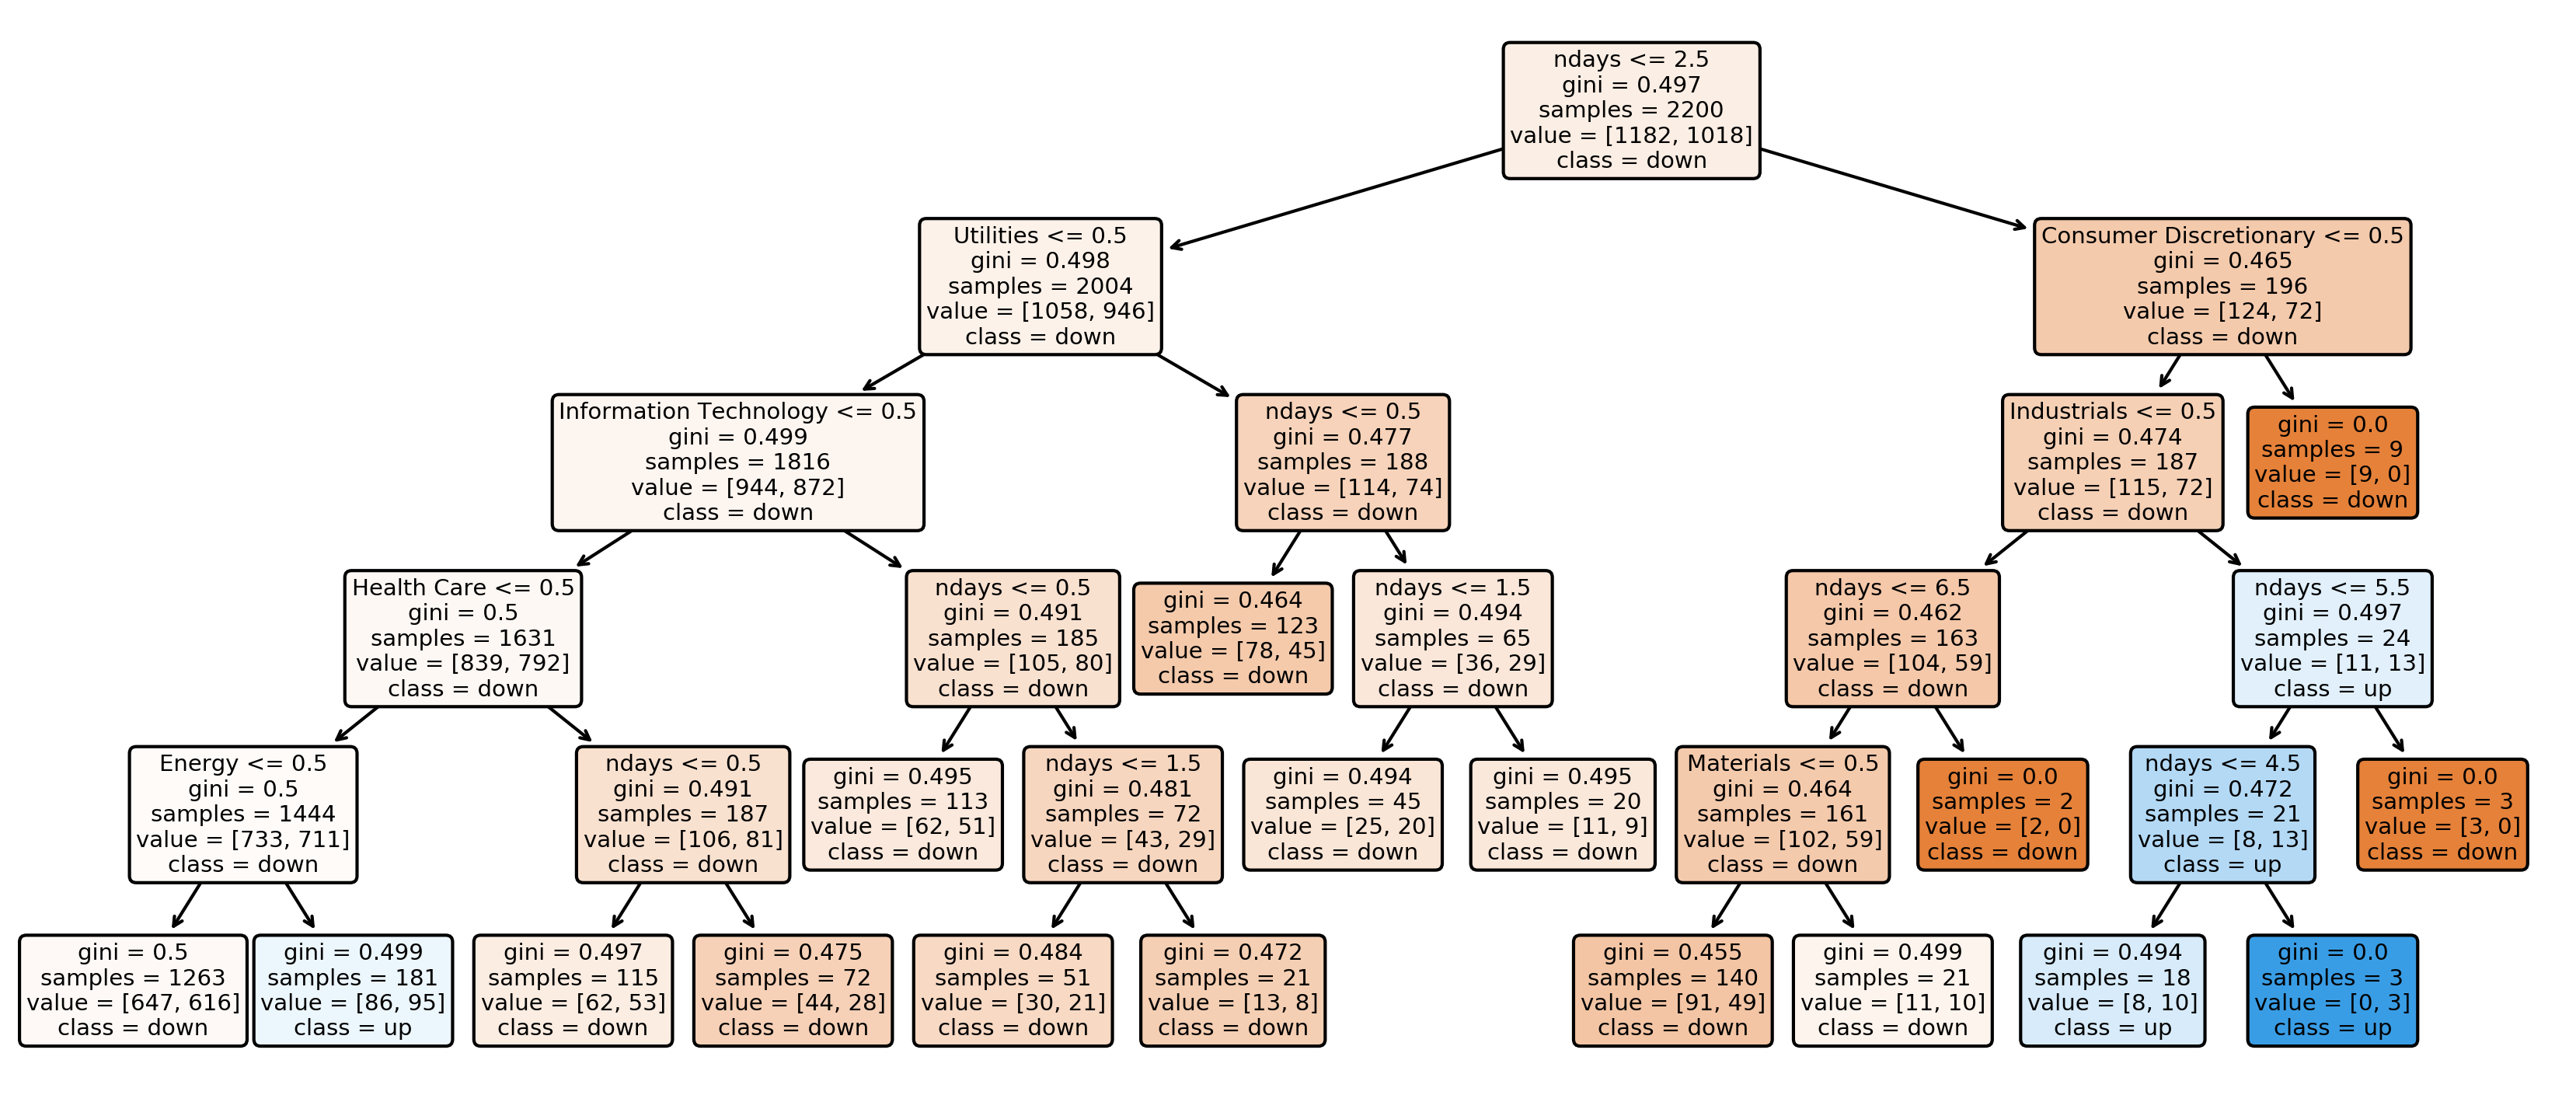

In [67]:
pipe.fit(X, y);
cats = categories.tolist() + ["ndays"]

plt.figure(dpi=300, figsize=(14, 6))
plot_tree(pipe.named_steps["tree"],
          feature_names=cats,
          class_names=["down", "up"],
         rounded=True,
         filled=True,
         fontsize=7);

In [68]:
cross_validate(pipe, X, y, cv=5, scoring=["precision", "recall"])

/Users/gerardoduran/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'fit_time': array([0.00551677, 0.00511575, 0.00641918, 0.00828791, 0.006284  ]),
 'score_time': array([0.00486016, 0.00419307, 0.00557995, 0.00431299, 0.00935507]),
 'test_precision': array([0.47524752, 0.27419355, 0.4       , 0.4125    , 0.        ]),
 'test_recall': array([0.94117647, 0.08333333, 0.2745098 , 0.32512315, 0.        ])}

In [8]:
moons

(array([[-0.09821478,  0.39829029],
        [-0.37972495,  0.53213178],
        [ 1.3341397 ,  0.23372859],
        ...,
        [-0.3256327 ,  0.65045201],
        [ 0.27601752, -0.29412182],
        [ 1.09774777, -0.37445723]]),
 array([0, 0, 1, ..., 0, 1, 1], dtype=int64))

In [6]:
moons[0]

array([[-0.09821478,  0.39829029],
       [-0.37972495,  0.53213178],
       [ 1.3341397 ,  0.23372859],
       ...,
       [-0.3256327 ,  0.65045201],
       [ 0.27601752, -0.29412182],
       [ 1.09774777, -0.37445723]])

In [7]:
moons[1]

array([0, 0, 1, ..., 0, 1, 1], dtype=int64)

<img src="../files/misc/logo.gif" width=300/>
<h1 style="color:#872325">Árboles de Decisión</h1>

In [2]:
iris = load_iris()
plt.rcParams["figure.figsize"] = (8, 5)

Un **árbol de decisión** es un algoritmo de _machine learning_ basado en la toma de decisiones binarias.

Una primera manera de armar un árbol de decisión sería creando una función basada en una seríe de *inputs* e *if-else statements* tal que modelen la lógica que seguiríamos para resolver un problema.

```python
def f(x1, x2):
    if x1 <= t1:
        if x2 <= t2:
            return R1
        else:
            return R2
    else:
        if x1 <= t3:
            return R3
        else:
            if x2 <= t4:
                return R4
            else:
                return R5
        
```

Este mismo programa puede ser representado como un grafo de la siguiente manera:

---

![](./images/tree.png)

* A cada **nodo** del árbol, preguntamos si el predicado es verdadero o falso
* El número total de nodos es conocido como la **profundidad** del árbol

> Crear un árbol de decisión en base a nuestras propias experiencias podría resultar tedioso de programar y potencialmente sesgado a nuestras creencias.

Buscamos entonces una manera *automatica* de construir una función de decisión.

## Árbol de Decisión Regresivo
### Estimando variables continuas

La finalidad de un árbol de regresión es encontrar una función $\hat f: \mathbb{R}^M \to \mathbb{R}$ de la forma

$$
    \hat f({\bf x}) = \sum_{m=1}^M C_m \mathbb{1}_{{\bf x} \in R_m}
$$

Dónde
* $R_i$ es la $i$-ésima región
* $C_i$ es el valor correspondiente a la $i$-ésima región

La manera de entrenar un árbol de decisión es seleccionando entre *variables* y *puntos de corte* (la topología del árbol).

Consideramos la función objetivo de un árbol de decisión como:

$$
    \min{j, s}\left[\min_{C_1}\sum_{x_i \in R_1(j, s)}(y_i - C_1)^2 + \min_{C_2}\sum_{x_i \in R_1(j, s)}(y_i - C_2)^2\right]
$$

Dónde:
* $R_1(j, s) = \{x | x_j \leq s\}$

## Árbol de Decisión 
### Estimando variables Categóricas

$$
    \hat p_{m,k}= \frac{1}{N_m}\sum_{\{n|x_n\in R_m\}}\mathbb{1}_{t_n = k}
$$

Con función de costos:
1. Gini Index:
$$
    \sum_{k=1}^K \hat p_{m,k} ( 1- \hat p_{m,k}) 
$$

2. Cross-entropy

$$
    -\sum_{k=1}^K \hat p_{m,k}\log\hat p_{m,k}
$$

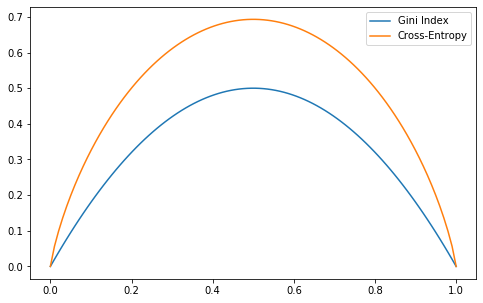

In [57]:
p = np.linspace(1e-5, 1-1e-9, 100)

gini = p * (1 - p) + (1 - p) * p
xentropy = -(p * np.log(p) + (1 - p) * np.log(1 - p))

plt.plot(p, gini, label="Gini Index")
plt.plot(p, -p * np.log(p) - (1 - p) * np.log(1 - p) , label="Cross-Entropy")
plt.legend()

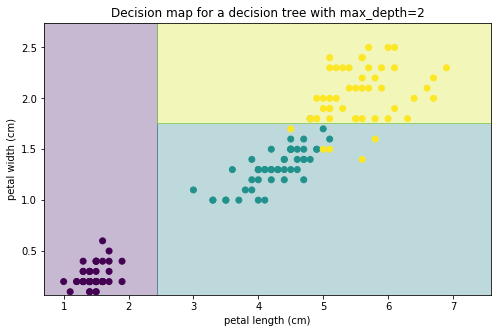

In [10]:
iris = load_iris()
X, y = iris.data[:,2:], iris.target
max_depth = 2
tree_clf = DecisionTreeClassifier(max_depth=max_depth)
tree_clf.fit(X, y)

x1min, x2min = X.min(axis=0) * 0.7
x1max, x2max = X.max(axis=0) * 1.1

x1map, x2map = np.mgrid[x1min:x1max:0.01, x2min:x2max:0.01]
xpred = np.c_[x1map.reshape(-1,1), x2map.reshape(-1,1)]
ypred = tree_clf.predict(xpred).reshape(x1map.shape)
plt.contourf(x1map, x2map, ypred, alpha=0.3)
plt.scatter(*X.T, c=y)
plt.title(f"Decision map for a decision tree with max_depth={max_depth}")
plt.xlabel(iris.feature_names[2])
plt.ylabel(iris.feature_names[3]);

In [12]:
# Estimando probabilidades en un árbol de decisión
Xt = [[5, 1.5], [5, 1.0], [1, 1.0], [6, 2.5]]
for xt in Xt:
    x0, x1 = xt
    print(f"p(x0={x0}, x1={x1})", end=" ")
    print(tree_clf.predict_proba([xt]))

p(x0=5, x1=1.5) [[0.         0.90740741 0.09259259]]
p(x0=5, x1=1.0) [[0.         0.90740741 0.09259259]]
p(x0=1, x1=1.0) [[1. 0. 0.]]
p(x0=6, x1=2.5) [[0.         0.02173913 0.97826087]]


## Ejemplo:
Creando un árbol de decisión para estimar si una acción va a bajar al día siguiente o subir dado el número de veces que ha ido cayendo (*streaks*) y el sector al que pertenece

In [13]:
sp500_url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
sp500, *_ = pd.read_html(sp500_url)

In [14]:
sample = sp500.groupby("GICS Sector")["Symbol"].apply(lambda v: v.sample(2, random_state=314))
sample

GICS Sector                
Communication Services  340     NWSA
                        24     GOOGL
Consumer Discretionary  104      CMG
                        283       LB
Consumer Staples        51       ADM
                        370      PEP
Energy                  222      HAL
                        335      NOV
Financials              270      JPM
                        105       CB
Health Care             242      HUM
                        292      LLY
Industrials             45       AOS
                        460      UPS
Information Technology  40       APH
                        469     VRSN
Materials               166      ECL
                        308      MLM
Real Estate             475      VNO
                        134      CCI
Utilities               158      DUK
                        342      NEE
Name: Symbol, dtype: object

In [16]:
alphav_url = "https://www.alphavantage.co/query"
key = os.environ["ALPHA_VANTAGE_KEY"]
params = {
    "apikey": key,
    "function": "TIME_SERIES_DAILY",
    "symbol": None,
    "datatype": "csv",
    "outpusize": "full"
}

In [17]:
nelements = len(sample)
df = pd.DataFrame()

ix = 0
for (sector, nobs), ticker in tqdm(sample.iteritems(), total=nelements):
    params["symbol"] = ticker
    r = requests.get(alphav_url, params=params)
    ticker_df = pd.read_csv(StringIO(r.text))
    ticker_df = (ticker_df.set_index("timestamp")
                  [["close", "volume"]]
                  .rename({"close": f"close_{ticker}",
                           "volume": f"volume_{ticker}"}, axis=1))
    df = df.join(ticker_df, how="outer")
    ix += 1
    if ix % 5 == 0:
        sleep(61)

In [19]:
df_close = df[[c for c in df.columns if "close" in c]]
close_count = df_close > df_close.shift(1)
close_count = close_count * 1

In [24]:
streaks = close_count != 0
df_streaks = streaks.cumsum()-streaks.cumsum().where(~streaks).ffill().fillna(0).astype(int)

df_streaks = df_streaks.reset_index().melt(id_vars="timestamp")
df_streaks["variable"] = df_streaks["variable"].apply(lambda v: v.replace("close_", ""))

df_streaks = df_streaks.merge(sample.reset_index(), left_on="variable", right_on="Symbol")
df_streaks = df_streaks.set_index("timestamp")

df_streaks["y"] = (df_streaks["value"].shift(-1) > 0) * 1

X = df_streaks[["value", "y", "GICS Sector"]]
X, y = X.drop("y", axis=1), X["y"]

In [30]:
categories = sample.reset_index()["GICS Sector"].unique()

In [32]:
csel = ColumnTransformer([
    ("ohe", OneHotEncoder(sparse=False, categories=[categories]), ["GICS Sector"])
], remainder="passthrough")

pipe = Pipeline([
    ("col_sel", csel),
    ("tree", DecisionTreeClassifier(max_depth=5, random_state=314))
])

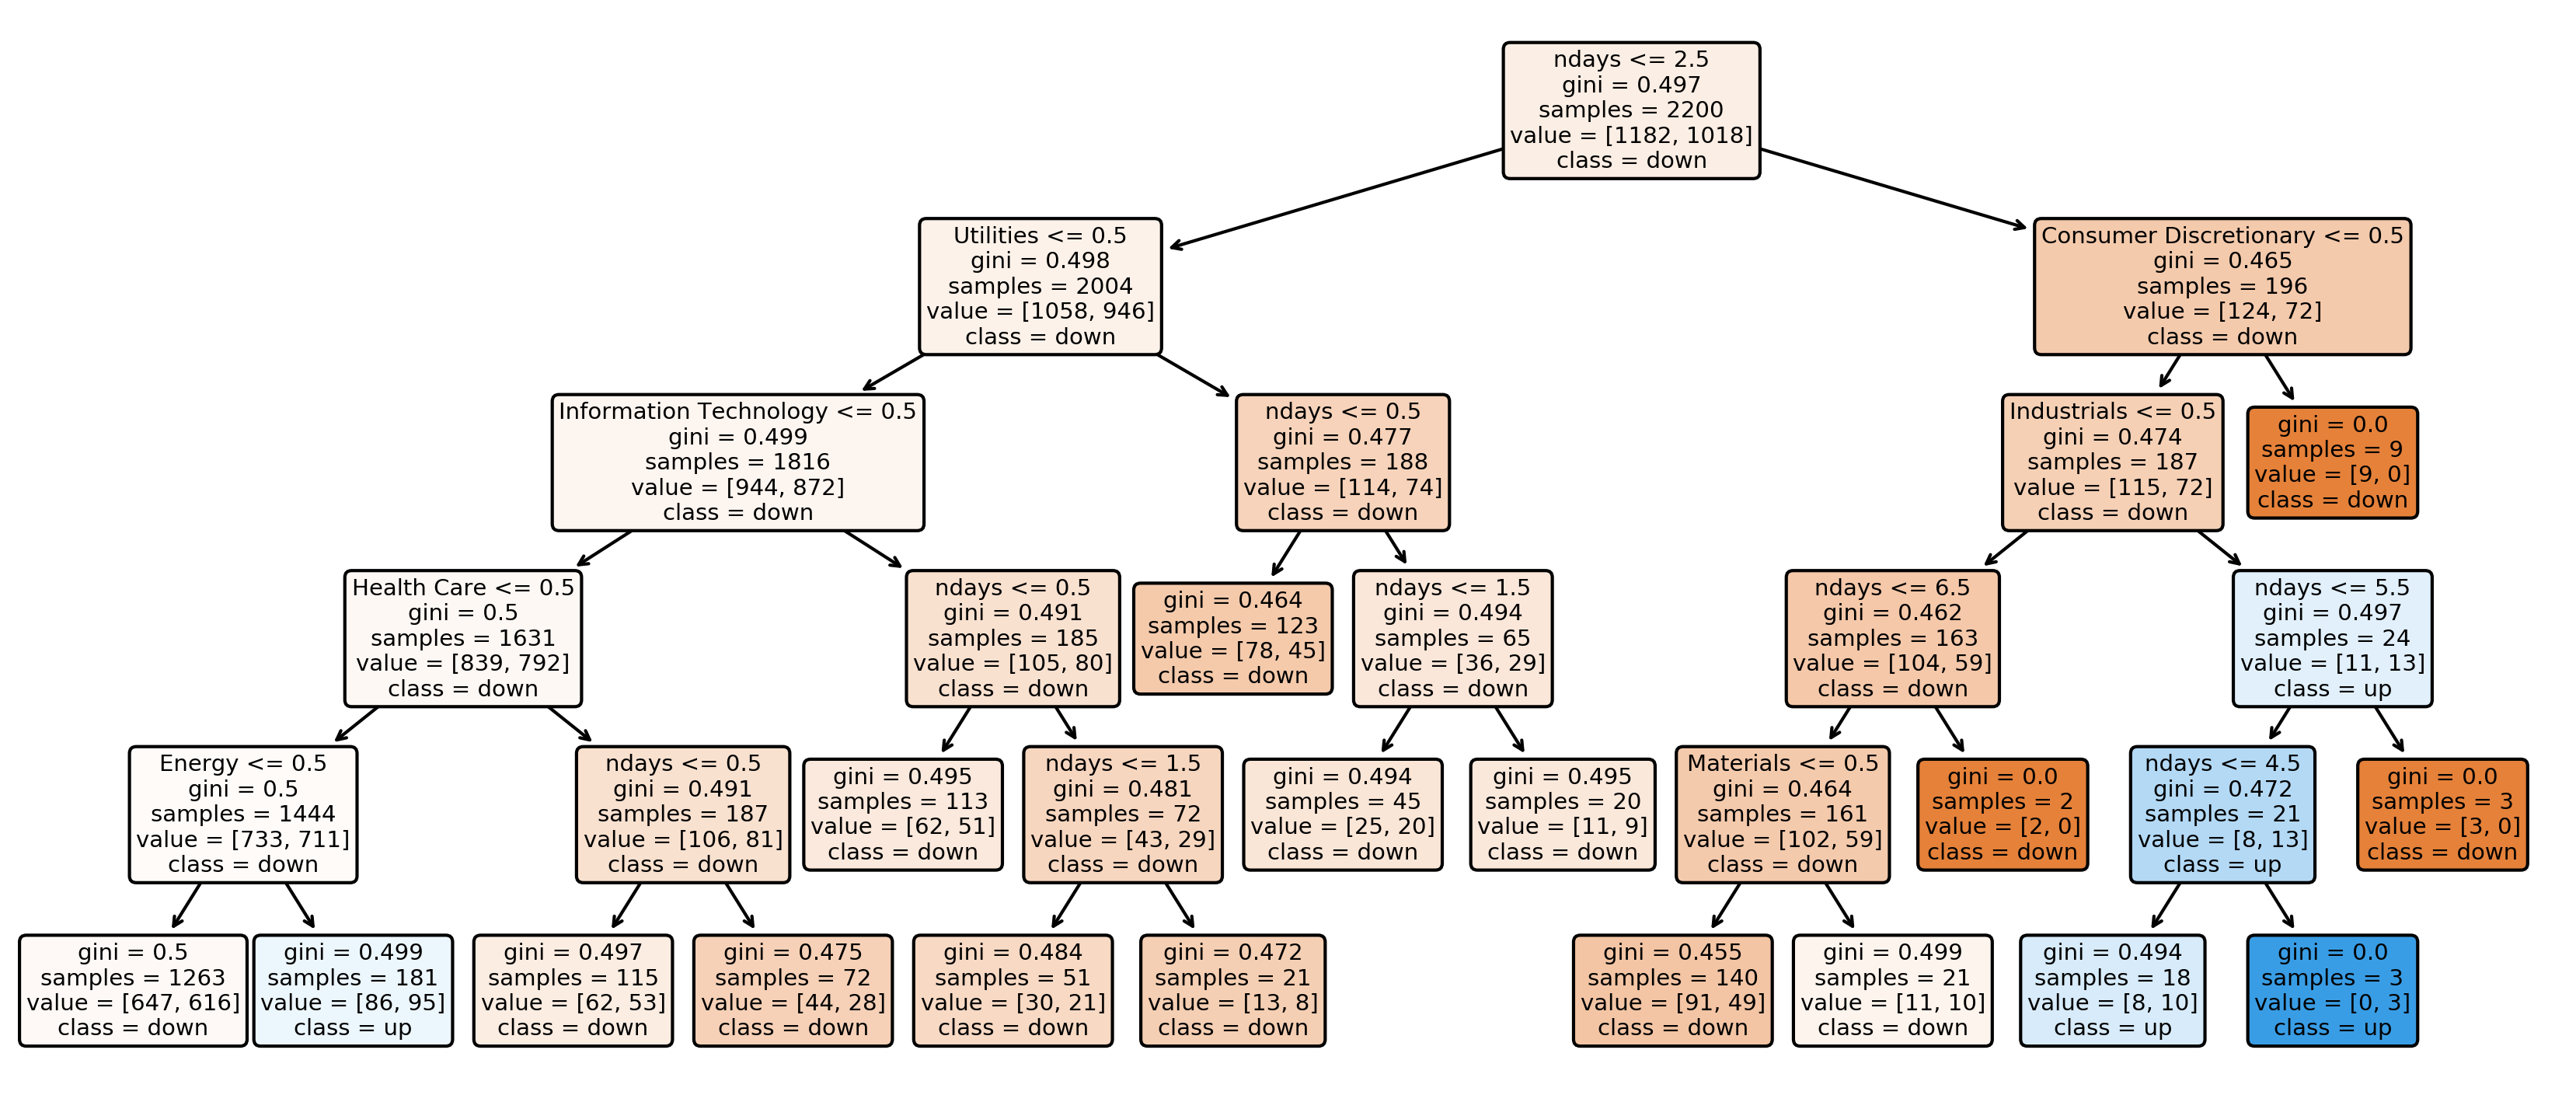

In [67]:
pipe.fit(X, y);
cats = categories.tolist() + ["ndays"]

plt.figure(dpi=300, figsize=(14, 6))
plot_tree(pipe.named_steps["tree"],
          feature_names=cats,
          class_names=["down", "up"],
         rounded=True,
         filled=True,
         fontsize=7);

In [68]:
cross_validate(pipe, X, y, cv=5, scoring=["precision", "recall"])

/Users/gerardoduran/opt/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'fit_time': array([0.00551677, 0.00511575, 0.00641918, 0.00828791, 0.006284  ]),
 'score_time': array([0.00486016, 0.00419307, 0.00557995, 0.00431299, 0.00935507]),
 'test_precision': array([0.47524752, 0.27419355, 0.4       , 0.4125    , 0.        ]),
 'test_recall': array([0.94117647, 0.08333333, 0.2745098 , 0.32512315, 0.        ])}